In [29]:
import pandas as pd
import numpy as np
#import PyQt5
#from ete3 import Tree, TreeStyle, NodeStyle
#import jax 
#import jax.numpy as jnp
import matplotlib.pyplot as plt
#from PIL import Image
from colour import Color
import matplotlib as mpl

In [4]:
# Load all files
#main_path = "C:/Users/buchm/OneDrive - University of Copenhagen/Papilonidae_dataset_v2/"
main_path = "/var/home/luka/proj/Papilonidae_dataset_v2"
metadata = pd.read_csv(main_path+"/Papilonidae_metadata.txt", sep=",")
landmarks = pd.read_csv(main_path+"/Papilionidae_landmarks.txt", sep="\t", header=None)
aligned = pd.read_csv(main_path+"/Papilionidae_aligned.txt", sep="\t", header=None)

In [5]:
def convert_to_slice(df_subgroup):
    x_coords = df_subgroup[df_subgroup.iloc[:, 1] == "x-coordinates"].iloc[:, 2:].values
    y_coords = -df_subgroup[df_subgroup.iloc[:, 1] == "y-coordinates"].iloc[:, 2:].values
    return np.column_stack((x_coords.ravel(), y_coords.ravel()))

# Split dataframe by "Name" and convert each subgroup back to a 2D slice
groups = [group for _, group in aligned.groupby(aligned.iloc[:, 0])]
list_of_2d_slices = [convert_to_slice(group) for group in groups]
butterflies = np.dstack(list_of_2d_slices)

In [6]:
def select_species(species, meta, marks):
    idx = meta["species"]==species
    if np.sum(idx)==0:
        print("Species not found")
        return None
    return marks[:, :, idx], meta[idx]

In [13]:
def get_data(species=None):
    main_path = "/var/home/luka/proj/Papilonidae_dataset_v2"
    metadata = pd.read_csv(main_path+"/Papilonidae_metadata.txt", sep=",")
    
    data = pd.read_csv(main_path+"/Papilionidae_aligned.txt", sep="\t", header=None)

    metadata = pd.read_csv(main_path+"/Papilonidae_metadata.txt", sep=",")
    
    groups = [group for _, group in data.groupby(data.iloc[:, 0])]
    list_of_2d_slices = [convert_to_slice(group) for group in groups]
    X = np.dstack(list_of_2d_slices)
    
    if species is not None:
        return select_species(species, metadata, X)
    else:
        return X, metadata

My work begins here


In [8]:
def sign_split(data):
    # split data into negative and positive x values
    neg = data[data[:, 0] < 0.]
    pos = data[data[:, 0] >= 0.]
    return neg, pos

In [9]:
def plot_butterfly(marks, s=2):
    plt.scatter(marks[:, 0], -marks[:, 1], s=s)
    plt.axis("equal")
    

In [10]:
def plot_wings(marks, sp=plt, scatter=False, dotsize=4):
    s = 50
    for n in [0, s]:
        xs = marks[n:s+n, 0]
        ys = -marks[n:s+n, 1]
        if scatter:
            sp.scatter(xs, ys, s=dotsize)
        else:
            sp.plot(xs, ys)

    sp.axis("equal")

In [11]:
def error_catch(marks):
    overlapR = False
    overlapL = False
    ro = None
    lo = None
    s = 50
    
    # indices of positive x-vals on left wing
    xl = np.where(marks[:s, 0] > 0.)
    if len(xl[0]) > 0:
        #print(f'Left wing has positive x-values at indices {xl}')
        overlapR = True
        lo = xl[0]
    
    # negative x-vals on right wing
    xr = np.where(marks[s:, 0] < 0.)
    if len(xr[0]) > 0:
        #print(f'Right wing has negative x-values at indices {xr}')
        overlapL = True
        ro = xr[0]
    
    #for i in [0, 1, 50, 51, 98, 99]:
    #    print(marks[i,0])
    #
    #if marks[0,0] > 0.:
    #    print("error")
        
    return overlapL, overlapR, lo, ro

sample_size = butterflies.shape[2]

errs = [(None,None) for i in range(sample_size)]

# list of erroneous indices
err_inds = []

np.set_printoptions(suppress=True)
for i in range(sample_size):
    r, l, lo, ro = error_catch(butterflies[:, :, i])
        
    if r or l:
        errs[i] = (ro, lo)
        err_inds.append(i)
        print(f"\nError in butterfly {i}")
    if r:
        print(f"Right wing has negative x-values at indices:\t{ro}")
    
    if l:
        print(f"Left wing has positive x-values at indices:\t{lo}")

# show errs
print(f'Number of errors: {len(err_inds)}')
print('Error indices:')
print(err_inds)
print(f'Sample size: {sample_size}')


Error in butterfly 5
Left wing has positive x-values at indices:	[0]

Error in butterfly 9
Right wing has negative x-values at indices:	[24]

Error in butterfly 10
Right wing has negative x-values at indices:	[24]

Error in butterfly 15
Left wing has positive x-values at indices:	[49]

Error in butterfly 25
Left wing has positive x-values at indices:	[ 0 49]

Error in butterfly 57
Left wing has positive x-values at indices:	[0]

Error in butterfly 62
Left wing has positive x-values at indices:	[ 0 49]

Error in butterfly 65
Left wing has positive x-values at indices:	[0]

Error in butterfly 76
Right wing has negative x-values at indices:	[24]

Error in butterfly 77
Right wing has negative x-values at indices:	[24]

Error in butterfly 78
Left wing has positive x-values at indices:	[49]

Error in butterfly 83
Right wing has negative x-values at indices:	[24]

Error in butterfly 85
Right wing has negative x-values at indices:	[24]

Error in butterfly 86
Left wing has positive x-values at

In [14]:
butterflies, metadata = get_data()

In [15]:
# plot distance between sequential landmarks
def plot_distances(marks):
    fig, subplt = plt.subplots()
    
    distances = np.linalg.norm(marks[1:] - marks[:-1], axis=1)
    # plt.plot(distances)
    # plt.xlabel("Landmark")
    # plt.ylabel("Distance")
    # plt.show()
    
    
    
    # landmark indexes sorted by distance to next landmark
    # (high to low)
    sorted_idx = np.argsort(distances)[::-1]

    # plot first k points of interest colored by distance to next point
    k = 3
    print(sorted_idx[:k])
    
    sorted_distances = distances[sorted_idx]
    print(sorted_distances[:k])
    
    #paircolors = mpl.color_sequences.to_rgba_array(plt.cm.viridis(np.linspace(0, 1, k)))
    #print(paircolors)
    
    #longpairs = np.zeros((k, 2))
    #for i in range(k):
    #    dot = sorted_idx[i]
    #    longpairs[i,0] = dot
    #    longpairs[i,1] = dot+1
    
    longpairs = np.column_stack((sorted_idx[:k], sorted_idx[:k] + 1)).astype(int)

    print(longpairs.shape, longpairs)
    plot_wings(marks, subplt)
    
    

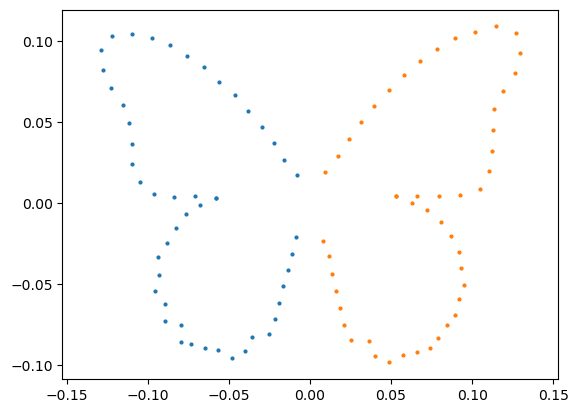

In [16]:
butterflies, _ = get_data()

plot_wings(marks=butterflies[:, :, 0], scatter=True, dotsize=4)

In [17]:
print(metadata)

              id                                 filename  \
0     1039027751                 1039027751_0_default.jpg   
1     1039028343             1039028343_0_default.jpg.jpg   
2     1039033323                 1039033323_0_default.jpg   
3     1039033725             1039033725_0_default.jpg.jpg   
4     1039037014             1039037014_0_default.jpg.jpg   
...          ...                                      ...   
2235   932851331              932851331_0_default.jpg.jpg   
2236   932851418              932851418_0_default.jpg.jpg   
2237   932851590  932851590_2011_07_19_IMG_091426.JPG.jpg   
2238   932851670              932851670_0_default.jpg.jpg   
2239   932851678              932851678_0_default.jpg.jpg   

                  species   latitude   longitude        family        order  \
0        Battus polydamas  26.805403  -82.280023  Papilionidae  Lepidoptera   
1     Papilio aristodemus  24.772380  -81.453743  Papilionidae  Lepidoptera   
2        Battus polydamas     

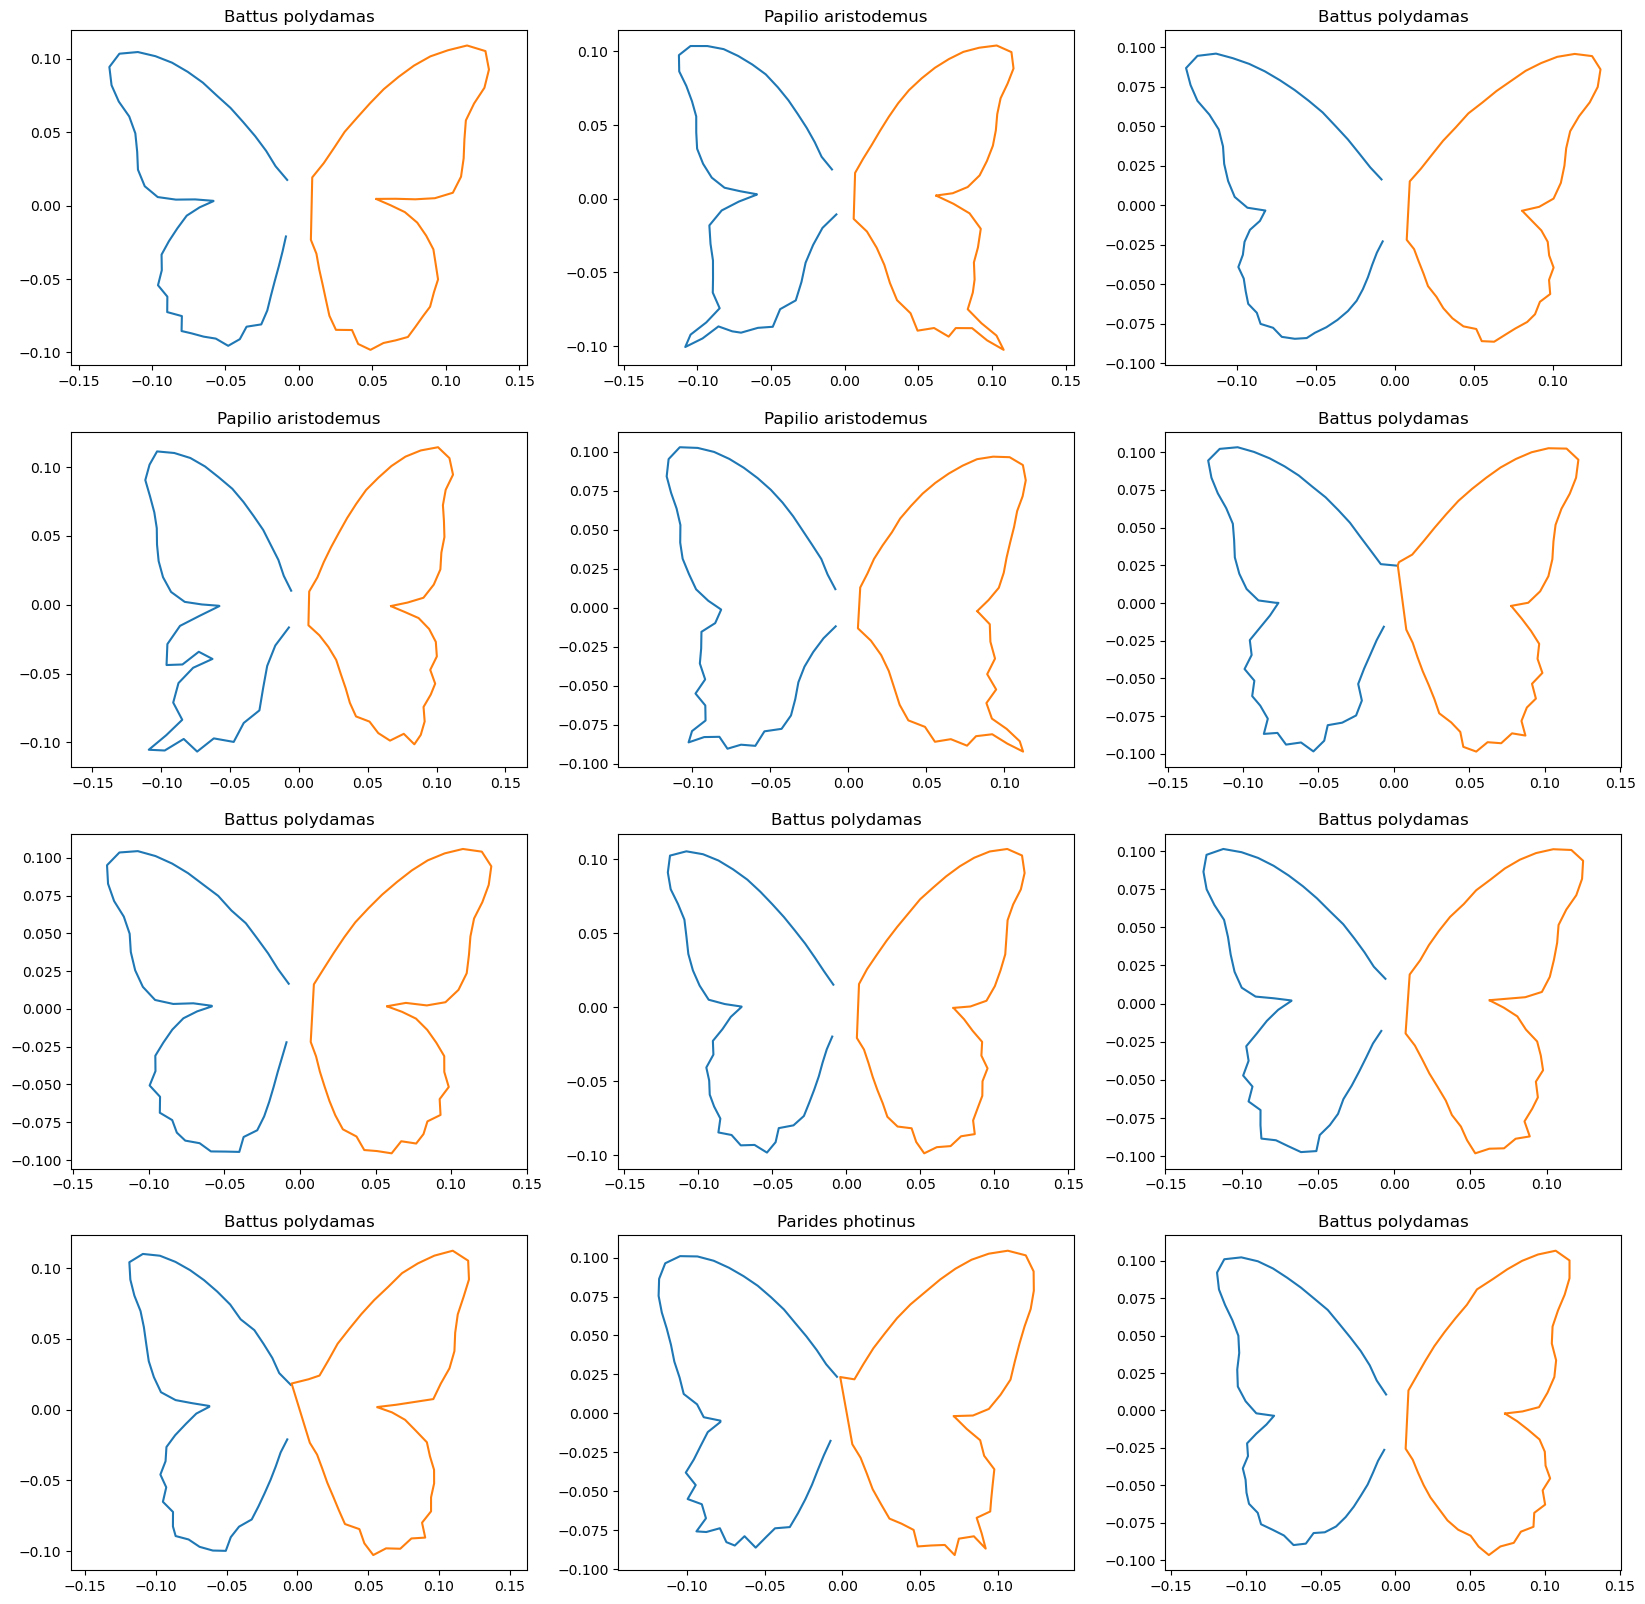

In [18]:
def plot_points(marks, n_row, n_col, meta=None):
    f = plt.figure(figsize=(20,20))
    for i in range(n_row*n_col):
        
        sp = plt.subplot(n_row,n_col,i+1)
        #plot_butterfly(marks[:, :, i])#, title=meta["species"][i])
        plot_wings(marks[:, :, i], sp)
        
        if meta is not None:
            sp.set_title(meta["species"][i])  # Fix: Replace sp.title with sp.set_title
        
plot_points(butterflies, 4, 3, metadata)

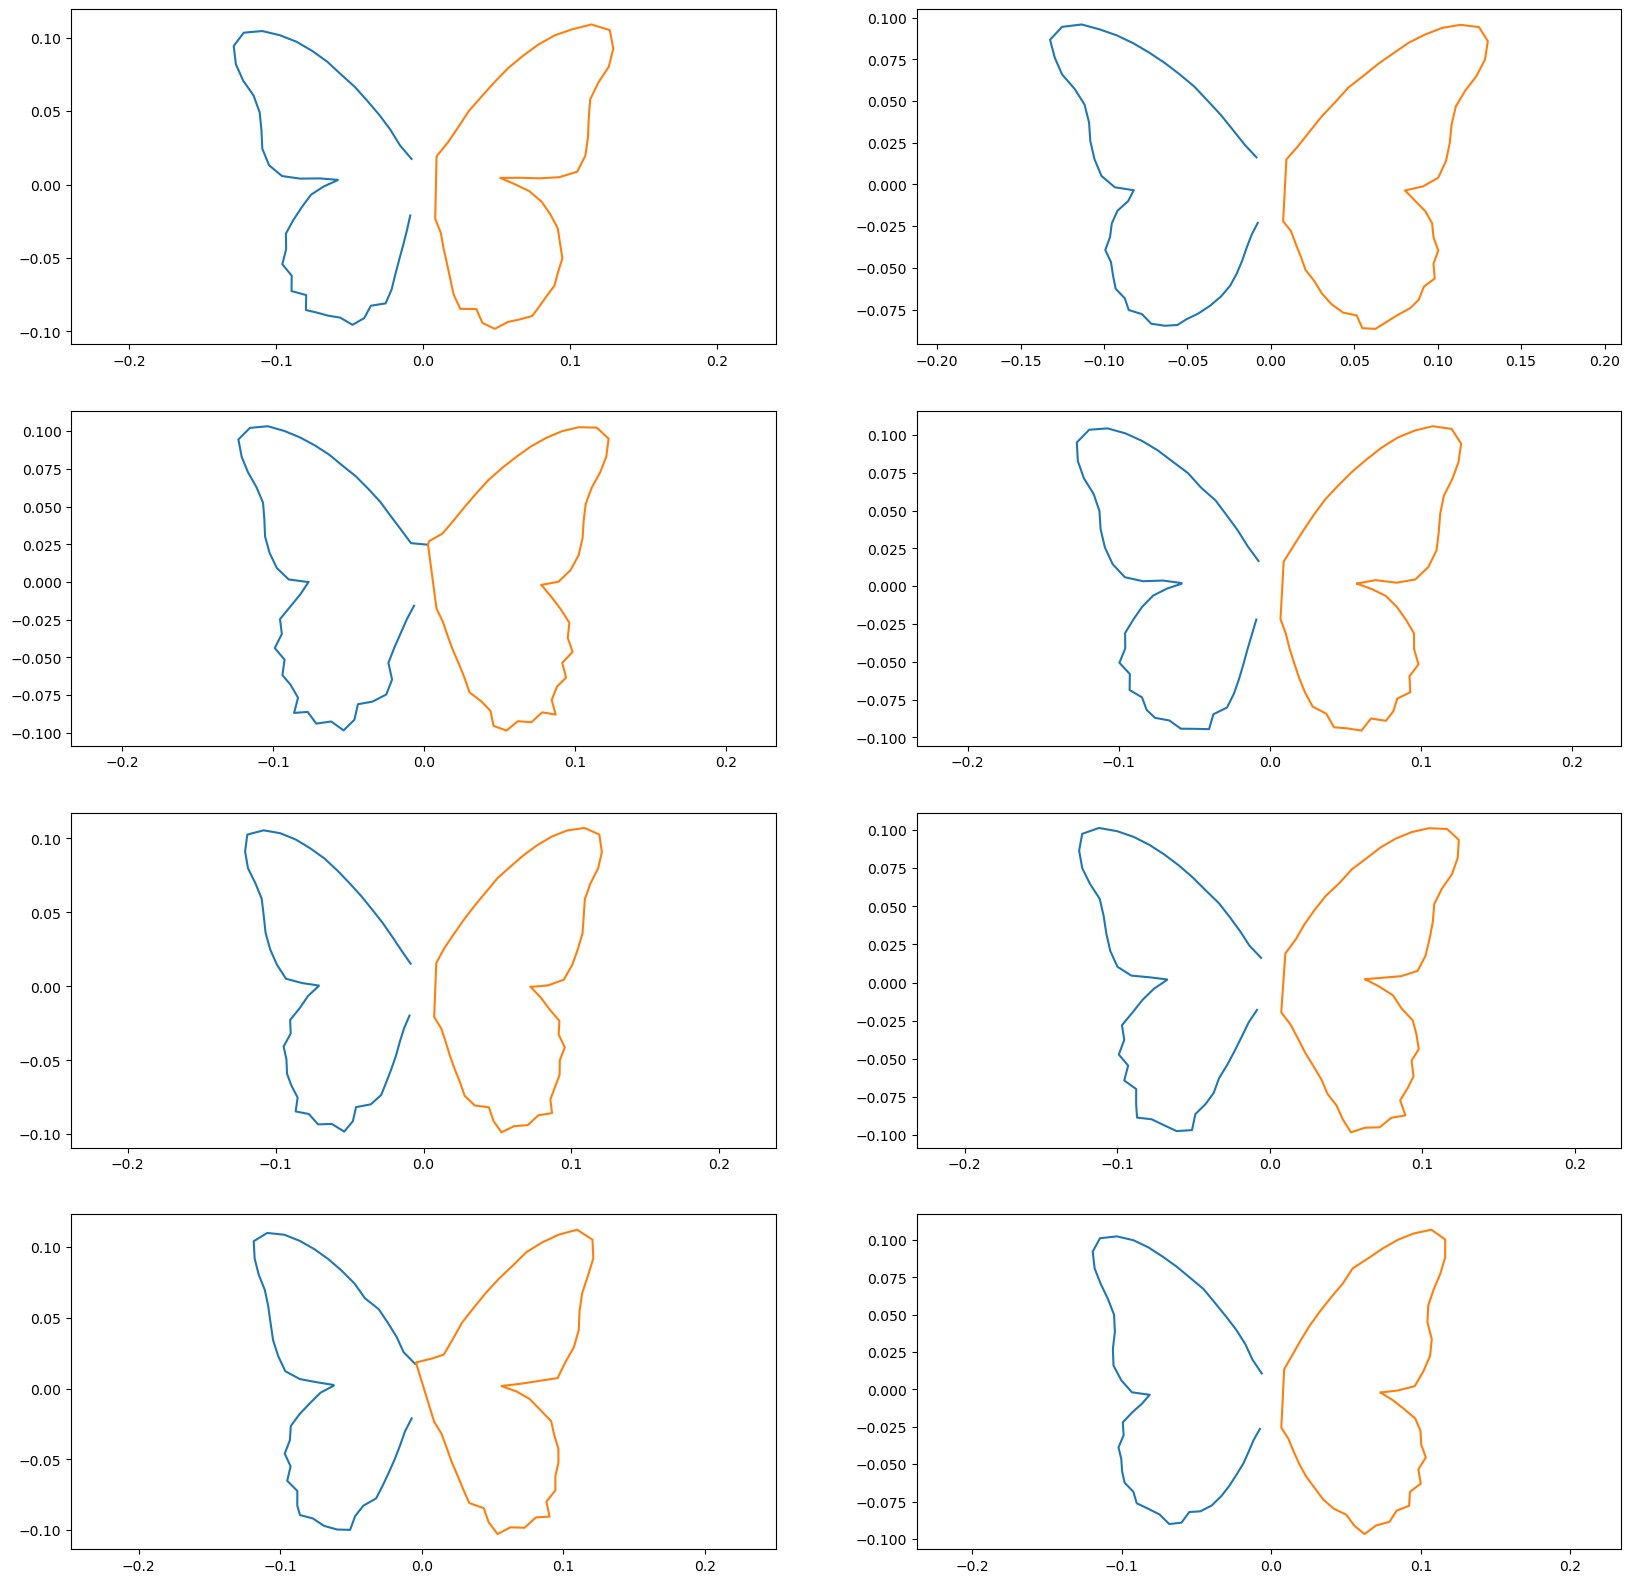

In [19]:
battus_landmarks, battus_metadata = select_species("Battus polydamas", metadata, butterflies)
plot_points(battus_landmarks, 4, 2)


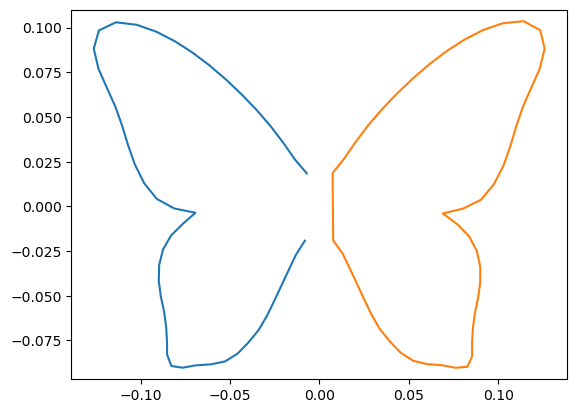

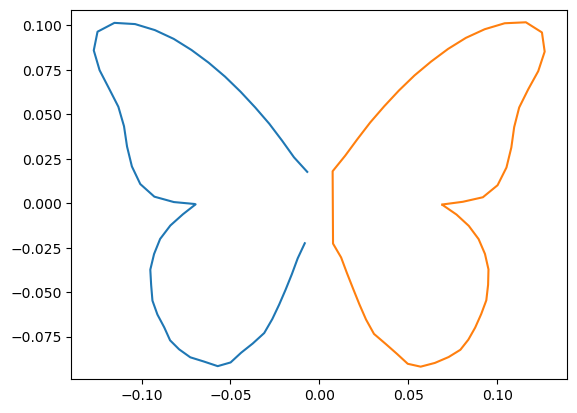

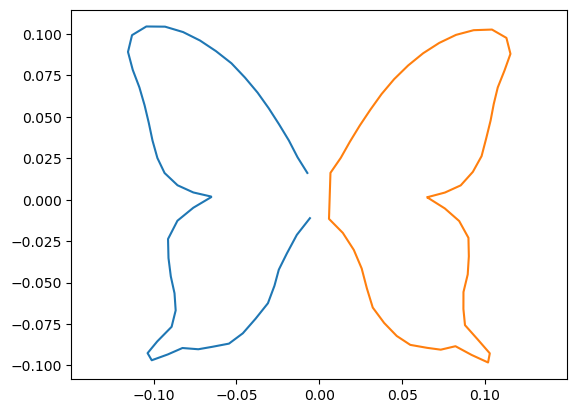

In [20]:
mean_butterfly = np.mean(butterflies, axis=2)
plot_wings(mean_butterfly)
plt.show()

battus_landmarks, _ = select_species("Battus polydamas", metadata, butterflies)
mean_battus = np.mean(battus_landmarks, axis=2)
plot_wings(mean_battus)
plt.show()

airstodemus_landmarks, _ = select_species("Papilio aristodemus", metadata, butterflies)
mean_aristodemus = np.mean(airstodemus_landmarks, axis=2)
plot_wings(mean_aristodemus)
plt.show()

In [21]:
def flat(marks):
    dims = len(marks.shape)
    if dims == 2:
        print("called flat() on 2d array, nothing happened.")
        return marks.reshape(marks.shape[0]*marks.shape[1])
    elif dims == 3:
        return marks.reshape(marks.shape[0]*marks.shape[1], marks.shape[2])
    else:
        raise ValueError("Invalid number of dimensions")

def unflat(marks, d=2):
    dims = len(marks.shape)
    if dims == 1:
        return marks.reshape(marks.shape[0]//d, d)
    elif dims == 2:
        return marks.reshape(marks.shape[0]//d, d, marks.shape[1])
    else:
        raise ValueError("Invalid number of dimensions")
    

print(flat(battus_landmarks).shape, battus_landmarks.shape)
print(flat(butterflies).shape, butterflies.shape)

(200, 118) (100, 2, 118)
(200, 2240) (100, 2, 2240)


In [22]:
a = np.arange(30).reshape(3, 2, 5)
b = flat(a)
c = unflat(b)
print(a, '\n\n', b, '\n\n', c)


[[[ 0  1  2  3  4]
  [ 5  6  7  8  9]]

 [[10 11 12 13 14]
  [15 16 17 18 19]]

 [[20 21 22 23 24]
  [25 26 27 28 29]]] 

 [[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]
 [25 26 27 28 29]] 

 [[[ 0  1  2  3  4]
  [ 5  6  7  8  9]]

 [[10 11 12 13 14]
  [15 16 17 18 19]]

 [[20 21 22 23 24]
  [25 26 27 28 29]]]


(100, 2, 118)
(200, 118)
(200,)
(100, 2)


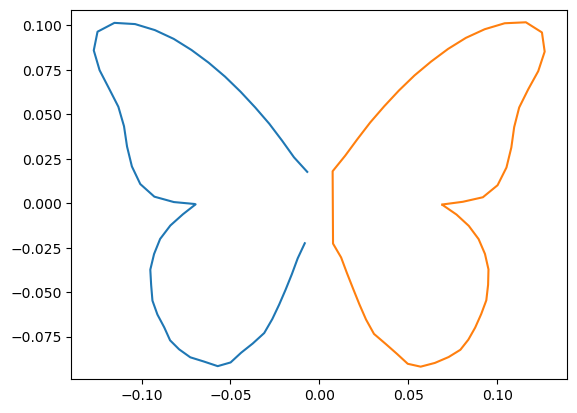

In [23]:
# the flat of the mean is the mean of the flat

x = battus_landmarks
print(x.shape)

x = flat(x)
print(x.shape)

x = np.mean(x, axis=1)
print(x.shape)

x = unflat(x)
print(x.shape)

# see if the arrays are equal, proving the point
np.allclose(mean_battus, x)

plot_wings(x)

In [24]:
def pca(data):
    X = flat(data)
    
    # center data
    X_mean = np.mean(X, axis=1)
    X_cent = X - X_mean[:,None]
    
    # get eigenvectors and eigenvalues from covariance matrix
    cov_mat = np.cov(X_cent)
    PCevals, PCevecs = np.linalg.eigh(cov_mat)
    
    return PCevals, PCevecs, X_cent


In [25]:
# transforms data from D to K dimensions
def transform(X, PCevecs, K=2):
    # select the eigenvectors corresponding to the K largest eigenvalues
    W = PCevecs[:, -K:]
    # project the data onto those components
    return X.T @ W

In [26]:
evals, evecs, cent_but = pca(butterflies)
features = transform(cent_but, evecs, K=2)

Proportion of variance explained by the first 1 principal components: 0.42275246822296253
Proportion of variance explained by the first 2 principal components: 0.643806322260234
Proportion of variance explained by the first 3 principal components: 0.7479976466808124
Proportion of variance explained by the first 4 principal components: 0.8288833383513163
Proportion of variance explained by the first 5 principal components: 0.8720324772318325
Proportion of variance explained by the first 6 principal components: 0.8922953084071006
Proportion of variance explained by the first 7 principal components: 0.9085019977558567
Proportion of variance explained by the first 8 principal components: 0.9191574978452733
Proportion of variance explained by the first 9 principal components: 0.9292258768242936
Proportion of variance explained by the first 10 principal components: 0.9371985831909271


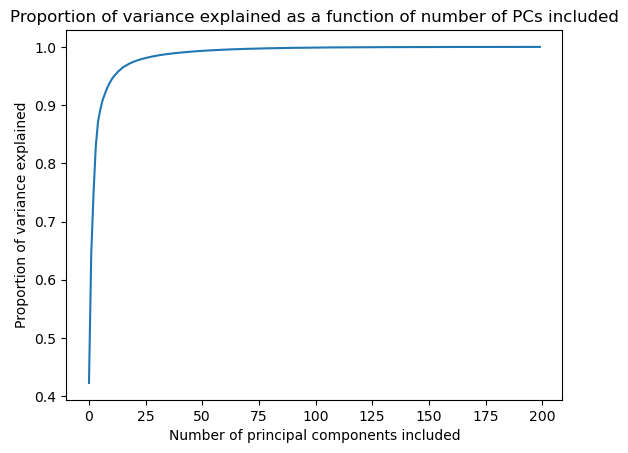

In [27]:
# reverse eigenvector order
evals_hi2lo = evals[::-1]

# variance explaned by first k components
variance_explained_per_component = evals_hi2lo/np.sum(evals_hi2lo)
cumulative_variance_explained = np.cumsum(variance_explained_per_component)

plt.plot(cumulative_variance_explained)
plt.xlabel('Number of principal components included')
plt.ylabel('Proportion of variance explained')
plt.title('Proportion of variance explained as a function of number of PCs included')

# Let's print out the proportion of variance explained by the first 10 PCs
for i in range(10):
    print('Proportion of variance explained by the first '+str(i+1)+' principal components:', cumulative_variance_explained[i])

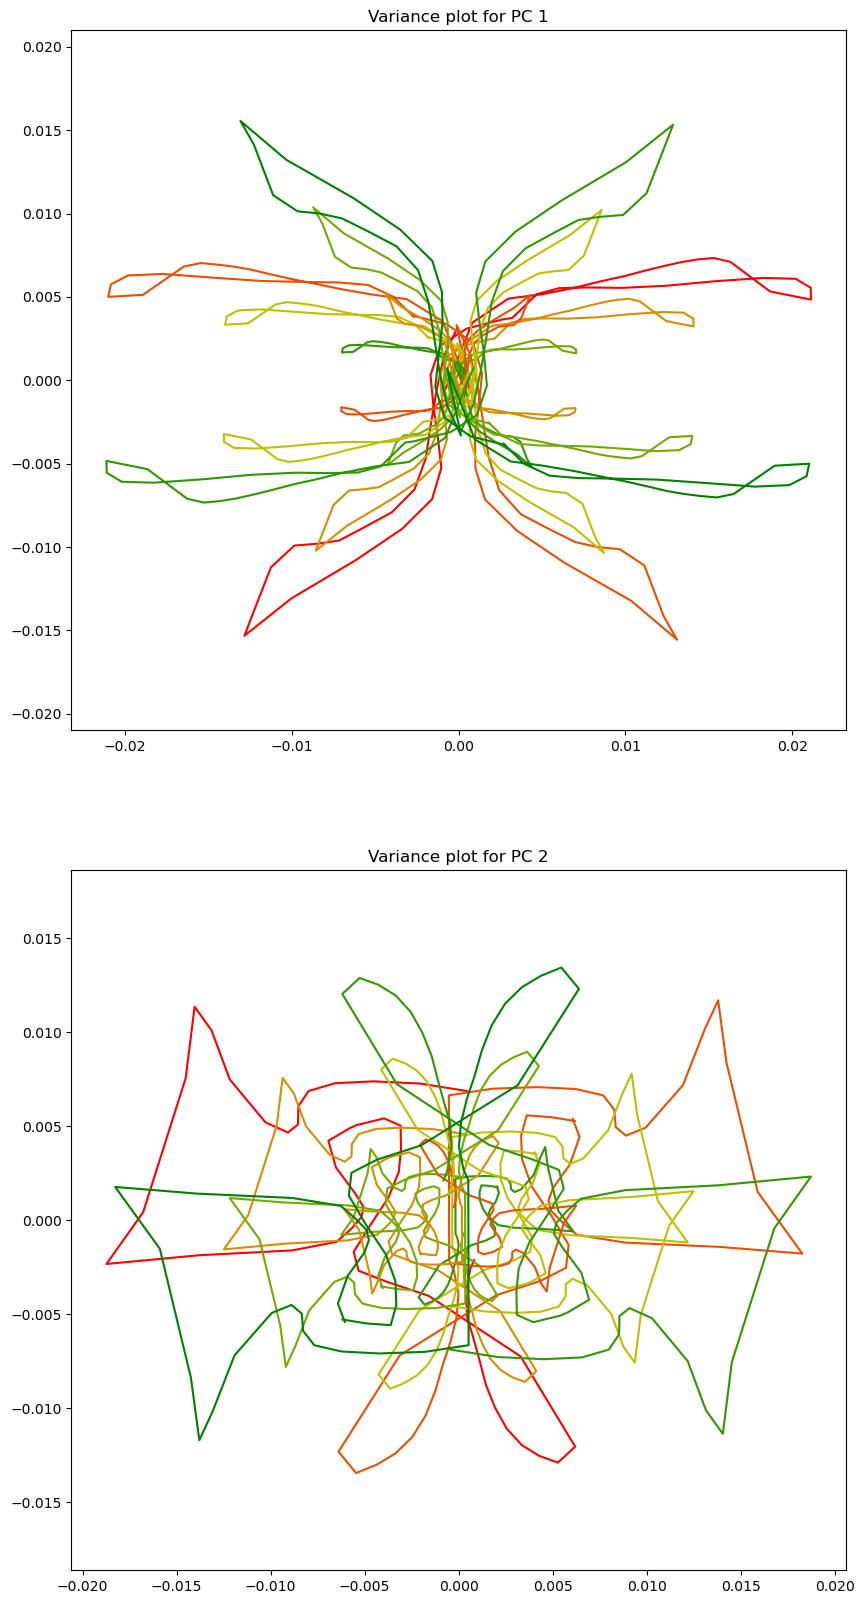

In [31]:


def var_plot(data, metadata, species=None, n=3, ks=[1,2]):
    # k:  component to analyze (counting from 1)
    # s: adjust exponent for better visualization
    
    if species is not None:
        data, _ = select_species(species, metadata, data)
    
    evals, evecs, data_flatcent = pca(data)
    cov = np.cov(data_flatcent)
    data_flatmean = np.mean(data_flatcent, axis=1)
    
    n2 = n*2+1
    gradient = list(Color("red").range_to(Color("green"), n2))
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', (gradient[i].hex for i in range(n2)))
    
    m = len(ks)
    
    plt.figure(figsize=(10, 10*m))
    
    a = np.arange(-n, n+1)
    
    for k in ks:
        s = ((k**0.1) * -0.2)
        
        evec = evecs[:, -k] # kth eigenvector
        lam = evals[-k]     # kth eigenvalue
        std = lam ** s
        ek_space = std * (evec @ cov)
        
        # modify data by devs[i] standard deviations of ek_space
        devs = std * a
        
        butterflies_along_pc = data_flatmean + devs[:, None] * ek_space
        
        subplot = plt.subplot(m, 1, k)
        
        if species is not None:
            subplot.set_title('Variance plot for PC '+str(k)+' of '+species)
        else:
            subplot.set_title('Variance plot for PC '+str(k))
        
        for i in range(n2):
            plot_wings(unflat(butterflies_along_pc[i]),subplot)


N=3
Ks=[1,2]


var_plot(data=butterflies, metadata=metadata, species=None, n=N,ks=Ks)